In [1]:
#include("../src/GaPSE.jl");

In [112]:
using DelimitedFiles, Plots, Dierckx, QuadGK, SpecialFunctions
using LsqFit, TwoFAST, LaTeXStrings

In [3]:
#=
FILE_F_MAP = "../data/F_REFERENCE.txt"
#FILE_PS = "../data/WideA_ZA_pk.dat"
FILE_PS = "file_pk.txt"
FILE_BACKGROUND = "../data/WideA_ZA_background.dat"
#FILE_IS = "tab_xi.txt"

z_min = 0.05
z_max = 0.20
θ_max = π / 2.0
params = GaPSE.CosmoParams(z_min, z_max, θ_max;
  k_min = 1e-8, k_max = 1000.0,
  Ω_b = 0.0489, Ω_cdm = 0.251020, h_0 = 0.70)
cosmo = GaPSE.Cosmology(params, FILE_BACKGROUND, FILE_PS, FILE_F_MAP)#, FILE_IS)

GaPSE.parameters_used(stdout, cosmo)
=#

In [4]:
tab_CLASS_pk = readdlm("../data/WideA_ZA_pk.dat", comments=true);
CLASS_ks = convert(Vector{Float64}, tab_CLASS_pk[:,1]);
CLASS_k_min, CLASS_k_max = CLASS_ks[begin], CLASS_ks[end]
CLASS_pks = convert(Vector{Float64}, tab_CLASS_pk[:,2]);
CLASS_spline = Spline1D(CLASS_ks, CLASS_pks);

In [5]:
tab_casto_pk = readdlm("file_pk.txt")
casto_ks = tab_casto_pk[:,1]
casto_k_min, casto_k_max = casto_ks[begin], casto_ks[end]
casto_pks = tab_casto_pk[:,2]
casto_spline = Spline1D(casto_ks, casto_pks);

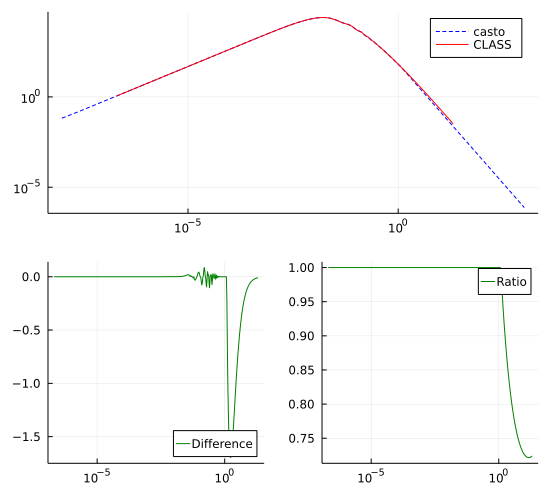

In [6]:
spline = casto_spline

p1 = plot([casto_ks, CLASS_ks] , 
    [casto_pks, CLASS_pks],
    xaxis=:log, yaxis=:log,
    lc=[:blue :red], ls=[:dash :solid], labels=["casto" "CLASS"])

p2 = plot(CLASS_ks, spline.(CLASS_ks) .- CLASS_pks, 
    xaxis=:log,label="Difference", lc=:green, legend=:bottomright)
p3 = plot(CLASS_ks, spline.(CLASS_ks) ./ CLASS_pks, xaxis=:log, label="Ratio", lc=:green, )

plot(p1, p2, p3, size=(550, 500), layout= @layout [ x ; y z ] )

In [127]:
function derivate_point(xp, yp, x1, y1, x2, y2)
    m2 = (y2 - yp)/(x2 - xp)
    m1 = (yp - y1)/(xp - x1)
    res = (m1 + m2)/2.0
    #println(res)
    return res
end

function derivate_vector(ixs, ys; N::Integer = 1, logscale=false)
     xs = !logscale ? ixs : begin
            fac = ixs[begin+1] / ixs[begin];
            [x/(fac^i) for (i,x) in enumerate(ixs)]
        end
    
    if N == 1
        real_vec = [derivate_point(xs[i], ys[i], xs[i-1], ys[i-1], xs[i+1], ys[i+1]) 
                for i in (N+1):(length(xs)-N)]
        return vcat(real_vec[begin], real_vec, real_vec[end])
    elseif N>1
        vec = [ derivate_point(xs[i], ys[i], xs[i-j], ys[i-j], xs[i+j], ys[i+j]) 
        for i in (N+1):(length(xs)-N), j in 1:N]
        real_vec = [sum(row)/N for row in eachrow(vec)]
        return vcat([real_vec[begin] for i in 1:N], real_vec,
            [real_vec[end] for i in 1:N] )
    else 
        throw(ErrorException(" N must be an integer >1, not $N!"))
    end
end


function spectral_index(ixs, ys; N::Integer=1, con=false, logscale=false)
    xs = !logscale ? ixs : begin
            fac = ixs[begin+1] / ixs[begin];
            [x/(fac^i) for (i,x) in enumerate(ixs)]
        end
    derivs = derivate_vector(xs, ys; N=N)
    if con == false
        return [x*d/y for (x,y,d) in zip(xs, ys, derivs)]
    else
        sec_derivs = derivate_vector(xs, derivs; N=N)
        vec = [x*d2/d for (x,d,d2) in zip(xs, derivs, sec_derivs)]
        return vec .+ 1.0 
    end
end


function mean_spectral_index(ixs, ys; N::Integer=1, con=false, logscale=false)
    vec = spectral_index(ixs, ys; N=N, con=con, logscale=logscale)[begin+2*N:end-2*N]
    return sum(vec)/length(vec)
end

power_law(x, si, b, a) = a .+ b .* (x.^si)

function power_law_b_a(ixs, ys, si; con=false, logscale=false)
    xs = !logscale ? ixs : begin
            fac = ixs[begin+1] / ixs[begin];
            [x/(fac^i) for (i,x) in enumerate(ixs)]
        end
    if con == true
        func_fitted(x, p) = power_law(x, si, p[1], p[2])
        fit = curve_fit(func_fitted, xs, ys, [0.5, 0.5])
        return coef(fit)
    else
        func_fitted(x, p) = power_law(x, si, p[1], 0.0)
        fit = curve_fit(func_fitted, xs, ys, [1.0])
        return vcat(coef(fit), 0.0)
    end
end

#=
power_law_b(x1, y1, x2, y2, si) = (y2 - y1)/(x2^si - x1^si)
function power_law_b(ixs, ys, sis; logscale=false)
    xs = !logscale ? ixs : begin
            fac = ixs[begin+1] / ixs[begin];
            [x/(fac^i) for (i,x) in enumerate(ixs)]
        end
    bs = [power_law_b(xs[i], ys[i], xs[i+1], ys[i+1], sis[i]) for i in 1:length(xs)-1]
    return vcat(bs, bs[end])
end

power_law_a(x, y, b, si) = y - b*(x^si)

function power_law_a(ixs, ys, bs, sis; logscale=false)
   xs = !logscale ? ixs : begin
            fac = ixs[begin+1] / ixs[begin];
            [x/(fac^i) for (i,x) in enumerate(ixs)]
        end
    [y - b*(x^si) for (x,y,b,si) in zip(xs,ys,bs,sis)]
end

power_law(x, si, b, a=0.0) = a + b *(x^si)
=#

power_law_b_a (generic function with 1 method)

In [198]:
function power_law_from_data(xs, ys, p0, x1::Number, x2::Number; con=false)
    @assert length(xs) == length(ys) "xs and ys must have same length"
    #Num = length(xs)
    new_xs = xs[x1 .< xs .< x2]
    new_ys = ys[x1 .< xs .< x2]
    
    #si = mean_spectral_index(xs, ys; N=N, con=con)
    si, b, a =
        if con ==false
            @assert length(p0) == 2 " si,b to be fitted, so length(p0) must be 2!"
            vec = coef(curve_fit((x,p)-> p[2] .* x .^p[1], 
                        new_xs, new_ys, p0 ))
            vcat(vec, 0.0)
        else
            @assert length(p0) == 3 " si,b,a to be fitted, so length(p0) must be 3!"
             coef(curve_fit((x,p) -> p[3] .+ p[2] .* x .^p[1], 
                    new_xs, new_ys, p0))
        end
 
    return si, b, a
end

function power_law_from_data(xs, ys, p0; con=false)
    power_law_from_data(xs, ys, p0, xs[begin], xs[end]; con=con)
end

#=
function power_law_from_data(xs, ys, x1::Number, x2::Number; N=3, 
        con=false, logscale=false)
    @assert length(xs) == length(ys) "xs and ys must have same length"
    Num = length(xs)
    new_xs = xs[x1 .< xs .< x2]
    new_ys = ys[x1 .< xs .< x2]
    
    sis = spectral_index(new_xs, new_ys; N = N, con = con, logscale = logscale)

    bs = power_law_b(new_xs, new_ys, sis, logscale = logscale)
    println(bs)
    
    as = con ? power_law_a(new_xs, new_ys, bs, sis; logscale = logscale) : 
        [0.0 for i in 1:length(new_xs)]
    r = 3*N
    a = sum(as[begin+r:end-r])/ (Num - 2*r)
    b = sum(bs[begin+r:end-r])/ (Num - 2*r)
    si = sum(sis[begin+r:end-r])/ (Num - 2*r)
    return si, b, a
end
=#

power_law_from_data (generic function with 4 methods)

In [180]:
xs = [i for i in 10:100]
ys = [4 + 3*i^(-2.5) for i in xs]
vec = spectral_index(xs, ys; con=true)[begin+4:end-4]
si = sum(vec)/length(vec)
coef(curve_fit((x,p)->power_law(x,p[1], p[2], p[3]), xs, ys, [0.5,0.5,0.5]))
#power_law_from_data(xs, ys; con=true)
#power_law_from_data(xs, ys, xs[begin], xs[end]; con=true)

3-element Vector{Float64}:
 -2.4999999995888973
  2.99999999697495
  3.9999999999998774

In [181]:
coef(curve_fit((x,p)->power_law(x,p[1], p[2]), 
    CLASS_ks[CLASS_ks .< 1e-3], CLASS_pks[CLASS_ks .<1e-3], [1.0, 1.0]))

2-element Vector{Float64}:
 0.9500843209188635
 2.768765794031179e6

In [189]:
power_law_from_data(CLASS_ks, CLASS_pks, [1.0, 1.0, 0.0], 1e-8, 1e-3; con=true)

(0.9485675414771996, 2.739954679739692e6, -1.5858283344458137)

In [341]:
function expanded_IPS(ks, pks; N = 3, con=false, logscale = true)
    k1, k2 = 1e-6, 1e-4
    k3, k4 = 1e1, 2e1
    k_in, k_end = 1e-12, 3e3
    
    N_k1 = findfirst(x->x>k1, ks) 
    N_k4 = findfirst(x->x>k4, ks) - 1
    
    p0_beg = con ? [1.0, 1.0, 1.0] : [1.0, 1.0]
    p0_end = con ? [-3.0, 1.0, 1.0] : [-3.0, 1.0]

    si_beg, b_beg, a_beg, step_beg, fac_beg =  ks[begin]>k_in ? 
        (power_law_from_data(ks, pks, p0_beg, k1, k2; con=con)..., 
        ks[begin+1] - ks[begin] ,  ks[begin] / ks[begin+1]) :
        (nothing, nothing, nothing, nothing, nothing)
    
    
    si_end, b_end, a_end, step_end, fac_end = ks[end]<k_end ?  
        (power_law_from_data(ks, pks, p0_end, k3, k4; con=con)... ,
        ks[end] - ks[end-1], ks[end] / ks[end-1]) :
        (nothing, nothing, nothing, nothing, nothing)
    
    println("$si_beg , $b_beg , $a_beg , $step_beg , $fac_beg")
    println("$si_end , $b_end , $a_end , $step_end , $fac_end")
    
    new_left_ks = ks[begin]>k_in ?
        #(new_left_temp = ks[N_k1]  .- step_beg .* cumsum([fac_beg^i for i in 1:1000])
        (new_left_temp = 10 .^ range(log10(k_in), log10(ks[N_k1]), step=-log10(fac_beg));
        unique(new_left_temp[new_left_temp .> k_in])) : nothing
    
    new_left_pks = isnothing(new_left_ks) ? nothing :
        [power_law(k, si_beg, b_beg, a_beg) for k in new_left_ks] 
        
    
    new_right_ks = ks[end]<k_end ? 
        (new_right_temp = 10 .^ range(log10(ks[N_k4+1]), log10(k_end), step=log10(fac_end));
        new_right_temp[new_right_temp .< k_end]) : nothing
    
        
    new_right_pks =  isnothing(new_left_ks) ? nothing : 
        [power_law(k, si_end, b_end, a_end) for k in new_right_ks]
    

    new_ks, new_pks = 
        if !isnothing(new_left_ks) && !isnothing(new_right_ks) 
            ( vcat(new_left_ks, ks[N_k1:N_k4], new_right_ks) , 
              vcat(new_left_pks, pks[N_k1:N_k4], new_right_pks) )
        elseif isnothing(new_left_ks) && !isnothing(new_right_ks) 
            ( vcat(ks[begin:N_k4], new_right_ks) , 
              vcat(pks[begin:N_k4], new_right_pks) )
        elseif !isnothing(new_left_ks) && isnothing(new_right_ks )
            ( vcat(new_left_ks, ks[N_k1:end]) , 
              vcat(new_left_pks, pks[N_k1:end]) )
        else
            ( ks , pks )
        end
    
    return new_ks, new_pks
end

expanded_IPS (generic function with 1 method)

In [342]:
1.0471285480510855^(-1)

0.9549925860212664

0.9598763714812466 , 3.0083212610355658e6 , 0.0 , 9.690358243199998e-9 , 0.9549925860214048
-2.641134521775953 , 91.60110694868098 , 0.0 , 0.9104197271200007 , 1.0471285480510855


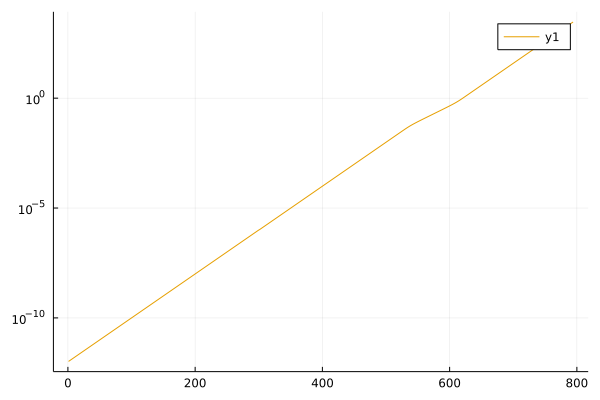

In [343]:
ks, pks = expanded_IPS(CLASS_ks, CLASS_pks)
plot(ks, yaxis=:log)#, xlims=(1e2, 1e3))

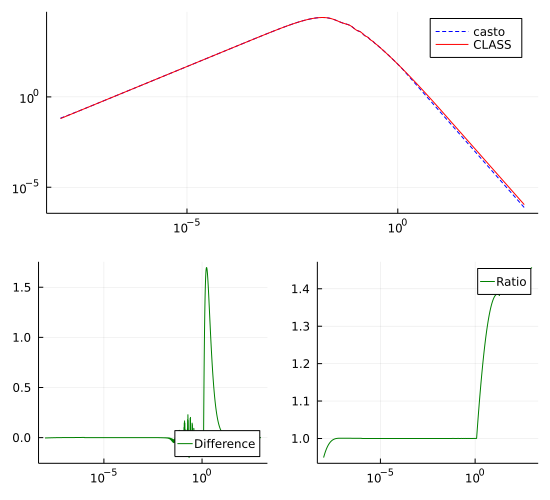

In [344]:
spline = Spline1D(ks, pks)

p1 = plot([casto_ks, casto_ks] , 
    [casto_pks, spline.(casto_ks)],
    xaxis=:log, yaxis=:log,
    lc=[:blue :red], ls=[:dash :solid], labels=["casto" "CLASS"])

p2 = plot(casto_ks, spline.(casto_ks).- casto_pks, 
    xaxis=:log,label="Difference", lc=:green, legend=:bottomright)
p3 = plot(casto_ks, spline.(casto_ks) ./ casto_pks, xaxis=:log, label="Ratio", lc=:green, )

plot(p1, p2, p3, size=(550, 500), layout= @layout [ x ; y z ] )

In [323]:
ks[begin]

2.056154633223e-7

In [328]:
ks = CLASS_ks
pks = CLASS_pks
k1, k2 = 1e-6, 1e-4
k3, k4 = 1e1, 2e1
k_in, k_end = 1e-10, 3e3

N_k1 = findfirst(x->x>k1, ks) 
N_k4 = findfirst(x->x>k4, ks) - 1

p0_beg = true ? [1.0, 1.0, 1.0] : [1.0, 1.0]

si_beg, b_beg, a_beg, step_beg, fac_beg =  ks[begin]>k_in ? 
    (power_law_from_data(ks, pks, p0_beg, k1, k2; con=true)..., 
    ks[begin+1] - ks[begin] ,  ks[begin] / ks[begin+1]) :
    (nothing, nothing, nothing, nothing, nothing)


println("$si_beg , $b_beg , $a_beg , $step_beg , $fac_beg")

new_left_ks = ks[begin]>k_in ?
    #(new_left_temp = ks[N_k1]  .- step_beg .* cumsum([fac_beg^i for i in 1:1000])
    (new_left_temp = 10 .^ range(log10(k_in), log10(ks[N_k1]), step=-log10(fac_beg));
    reverse(unique(new_left_temp[new_left_temp .> k_in]))) : nothing

new_left_pks = isnothing(new_left_ks) ? nothing :
    [power_law(k, si_beg, b_beg, a_beg) for k in new_left_ks] 

new_left_ks, new_left_pks

0.959814529273753 , 3.006619891359109e6 , -0.00790055390968966 , 9.690358243199998e-9 , 0.9549925860214048


(Float64[], Any[])

In [333]:
10 .^range(log10(k_in), log10(ks[N_k1]), step=-log10(fac_beg))

201-element Vector{Float64}:
 1.0e-10
 1.0471285480509327e-10
 1.0964781961432546e-10
 1.1481536214969968e-10
 1.2022644346175704e-10
 1.2589254117943722e-10
 1.3182567385566636e-10
 1.3803842646032028e-10
 1.4454397707463063e-10
 1.5135612484366528e-10
 1.5848931924616294e-10
 1.6595869074381535e-10
 1.7378008287500587e-10
 ⋮
 6.025595860780722e-7
 6.309573444841041e-7
 6.606934480117122e-7
 6.918309709232686e-7
 7.244359600795508e-7
 7.585775750339851e-7
 7.943282347293343e-7
 8.317637711079883e-7
 8.709635899616762e-7
 9.120108393617998e-7
 9.549925860276359e-7
 1.0000000000065238e-6

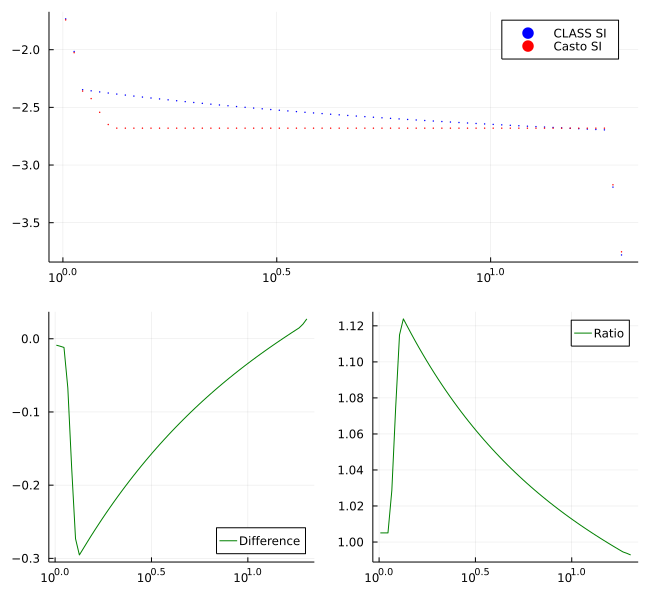

In [66]:
x_min = 1e0
x_max = 1e2

xs = CLASS_ks[x_min.< CLASS_ks .< x_max]
first_ys = CLASS_pks[x_min.< CLASS_ks .< x_max]
sec_ys = casto_spline.(xs)

first_sis = spectral_index(xs, first_ys; N=2, con=false)
sec_sis = spectral_index(xs, sec_ys; N=2, con=false)


p1 = scatter( [xs, xs], [first_sis, sec_sis] ,
    xscale=:log10, #yscale=:log10,
    label=["CLASS SI" "Casto SI"], color=[:blue :red], 
    markersize = [1 1], markerstrokewidth=[0 0] )

p2 = plot(xs, sec_sis .- first_sis, 
    xscale=:log10,
    label="Difference", lc=:green, legend=:bottomright)

p3 = plot(xs, sec_sis ./ first_sis, xscale=:log10, label="Ratio", lc=:green, )

plot(p1, p2, p3, size=(650, 600), layout= @layout [ x ; y z ] )

In [67]:
N = 2
#si_begin, si_end = CLASS_sis[begin], CLASS_sis[end];
casto_sis = spectral_index(casto_ks, casto_pks; N=N, con=true)
CLASS_sis = spectral_index(CLASS_ks, CLASS_pks; N=N, con=true);

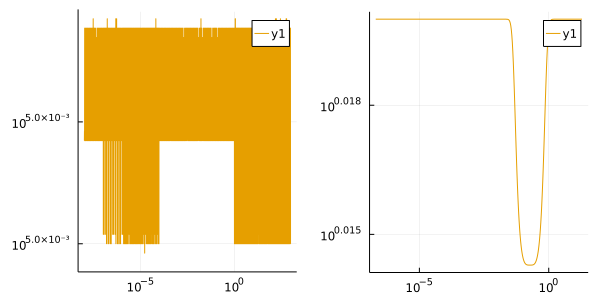

In [65]:
casto_xs = [casto_ks[i+1]/casto_ks[i] for i in 1:length(casto_ks)-1 ]
p1 = plot(casto_ks[begin:(end-1)], casto_xs, xaxis=:log, yaxis=:log)
CLASS_xs = [CLASS_ks[i+1]/CLASS_ks[i] for i in 1:length(CLASS_ks)-1 ]
p2 = plot(CLASS_ks[begin:(end-1)], CLASS_xs, xaxis=:log, yaxis=:log)

plot(p1,p2, size=(600, 300))

In [61]:
CLASS_si_of_sis = spectral_index(CLASS_ks[begin+N:end-N], CLASS_sis; 
                        N=N)[begin+N:end-N]
new_CLASS_ks = CLASS_ks[(begin +2*N):(end - 2*N)];

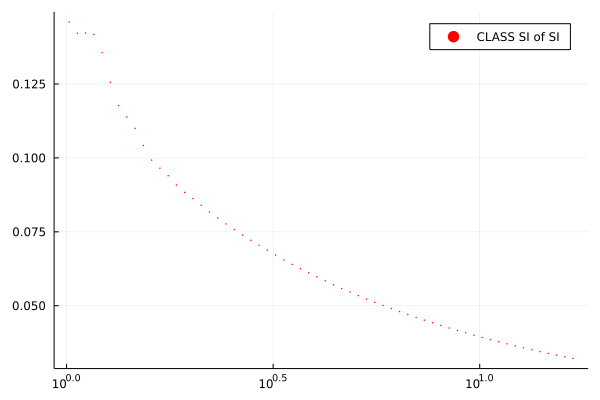

In [16]:
x_min = 1e0
x_max = 1e3

scatter(new_CLASS_ks[x_min.< new_CLASS_ks .< x_max], 
        CLASS_si_of_sis[x_min.< new_CLASS_ks .< x_max], 
    xscale=:log10, #yscale=:log10,
    label="CLASS SI of SI", color=:red, 
    markersize = 1, markerstrokewidth=0)

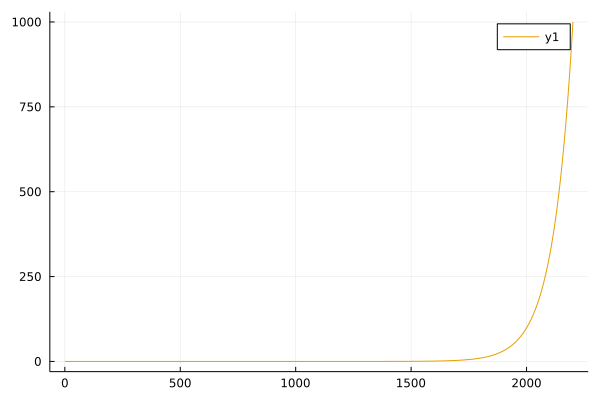

In [158]:
f = casto_ks[begin] / casto_ks[end]
xs = 
ys = casto_pks 
plot(xs)#, ys, xaxis=:log, yaxis=:log)

In [ ]:
xs = 